In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import *
import numpy as np

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell

from tabulate import tabulate

In [2]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

## 연습문제 1

In [3]:
df1 = pd.read_excel("https://data.hossam.kr/mldata/tree_weight.xlsx")
df1

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A
5,4.61,A
6,5.17,A
7,4.53,A
8,5.33,A
9,5.14,A


In [4]:
df1['group'].value_counts()

A    10
B    10
C    10
Name: group, dtype: int64

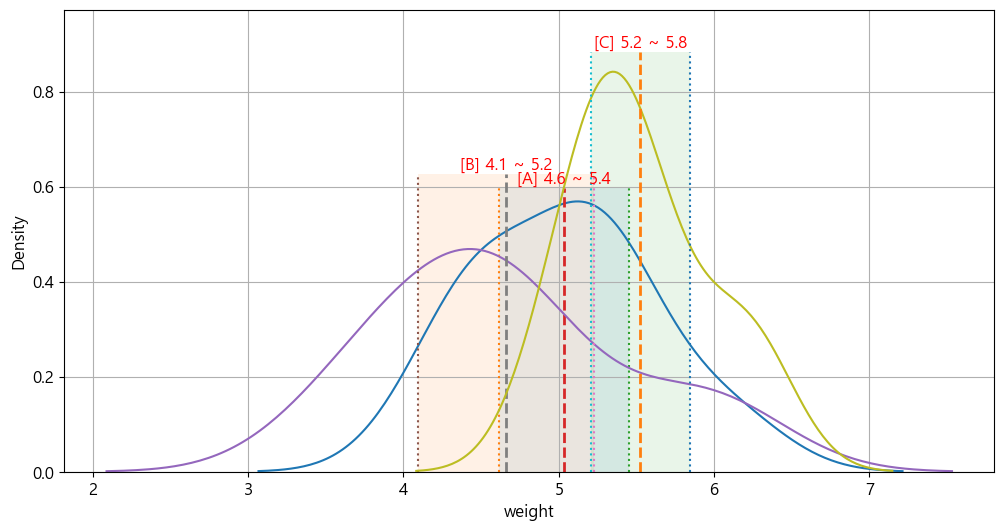

In [5]:
plt.figure(figsize = (12, 6))

for c in df1['group'].unique():
    #print(c)

    data = df1[df1['group'] == c]['weight']                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()



In [6]:
for c in df1['group'].unique():
    s, p = normaltest(df1[df1['group'] == c]['weight'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[A] statistic: 0.233, p-value: 0.890, 정규성 충족 여부: True
[B] statistic: 0.968, p-value: 0.616, 정규성 충족 여부: True
[C] statistic: 1.013, p-value: 0.603, 정규성 충족 여부: True


In [7]:
normal_dist = True      # 정규성 만족 여부
data = df1.copy()    # 원본 데이터 복사
fields = []
for i in data['group'].unique():
    tmp = data[data['group'] == i]['weight']
    fields.append(tmp)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 2.879, p-value: 0.237, 등분산성 충족 여부: True


In [8]:
s, p = f_oneway(*fields)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 4.846, p-value: 0.016, 대립가설 채택'

- p-value가 0.016으로 귀무가설이 기각되어 소나무 품종에 따른 무게는 차이가 있다.

In [9]:
lm = ols('weight ~ C(group)', data=df1).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,3.76634,1.883170,4.846088,0.01591
Residual,27.0,10.49209,0.388596,NaN,NaN


In [10]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 4.846, p-value: 0.016, 대립가설 채택'

In [11]:
tukey = pairwise_tukeyhsd(df1['weight'], df1['group'], alpha = 0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.371,0.3909,-1.0622,0.3202,False
A,C,0.494,0.198,-0.1972,1.1852,False
B,C,0.865,0.012,0.1738,1.5562,True


- 구체적으로는 B와 C의 비교에서 C가 유의미하게 중량이 더 높았다.

## 연습문제 2

In [12]:
df2 = pd.read_excel("https://data.hossam.kr/mldata/poisons.xlsx")
df2

,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1
...,...,...,...
355,4.7,P3,T4
356,4.9,P3,T4
357,4.9,P3,T4
358,4.5,P3,T4


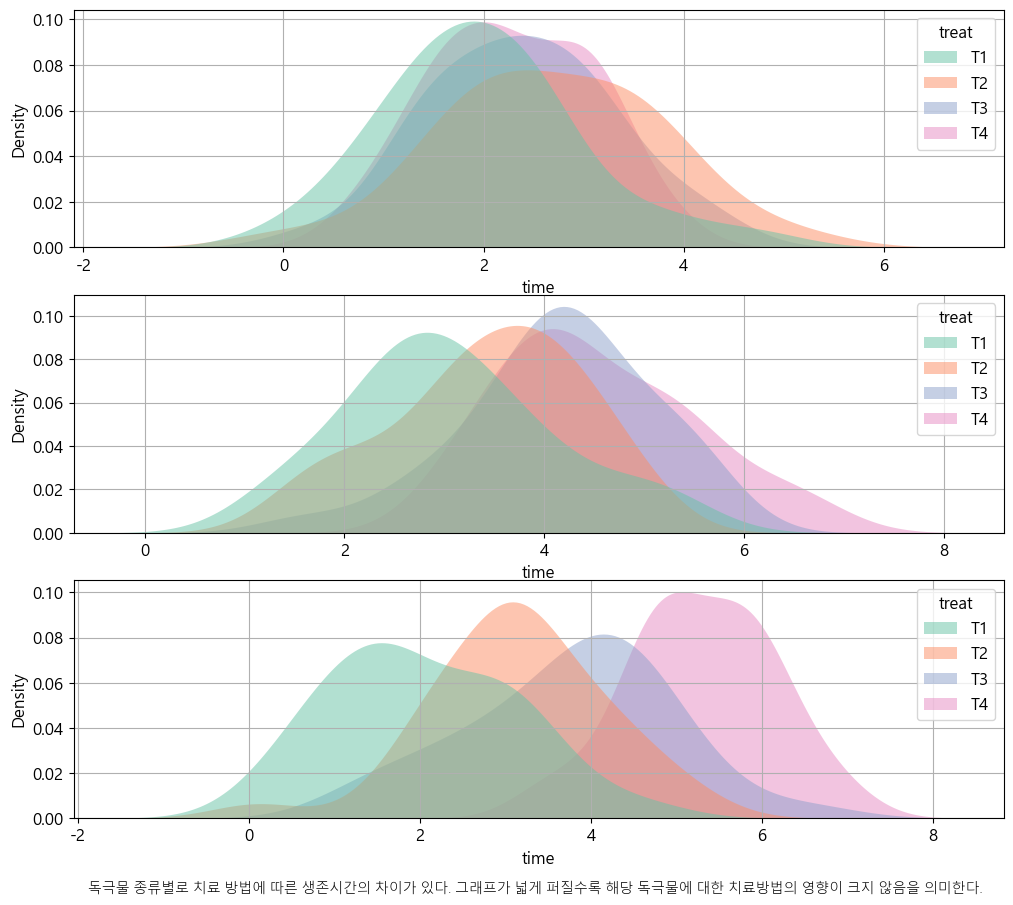

In [13]:
poison = df2['poison'].unique()
s = len(poison)

fig, ax = plt.subplots(s, 1, figsize=(12, 3.5*s))

for i, v in enumerate(ax):
    data = df2[df2['poison'] == poison[i]]
    sb.kdeplot(data=data, x='time', hue='treat', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()

txt = """독극물 종류별로 치료 방법에 따른 생존시간의 차이가 있다. 그래프가 넓게 퍼질수록 해당 독극물에 대한 치료방법의 영향이 크지 않음을 의미한다."""

plt.figtext(0.51, 0.05, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

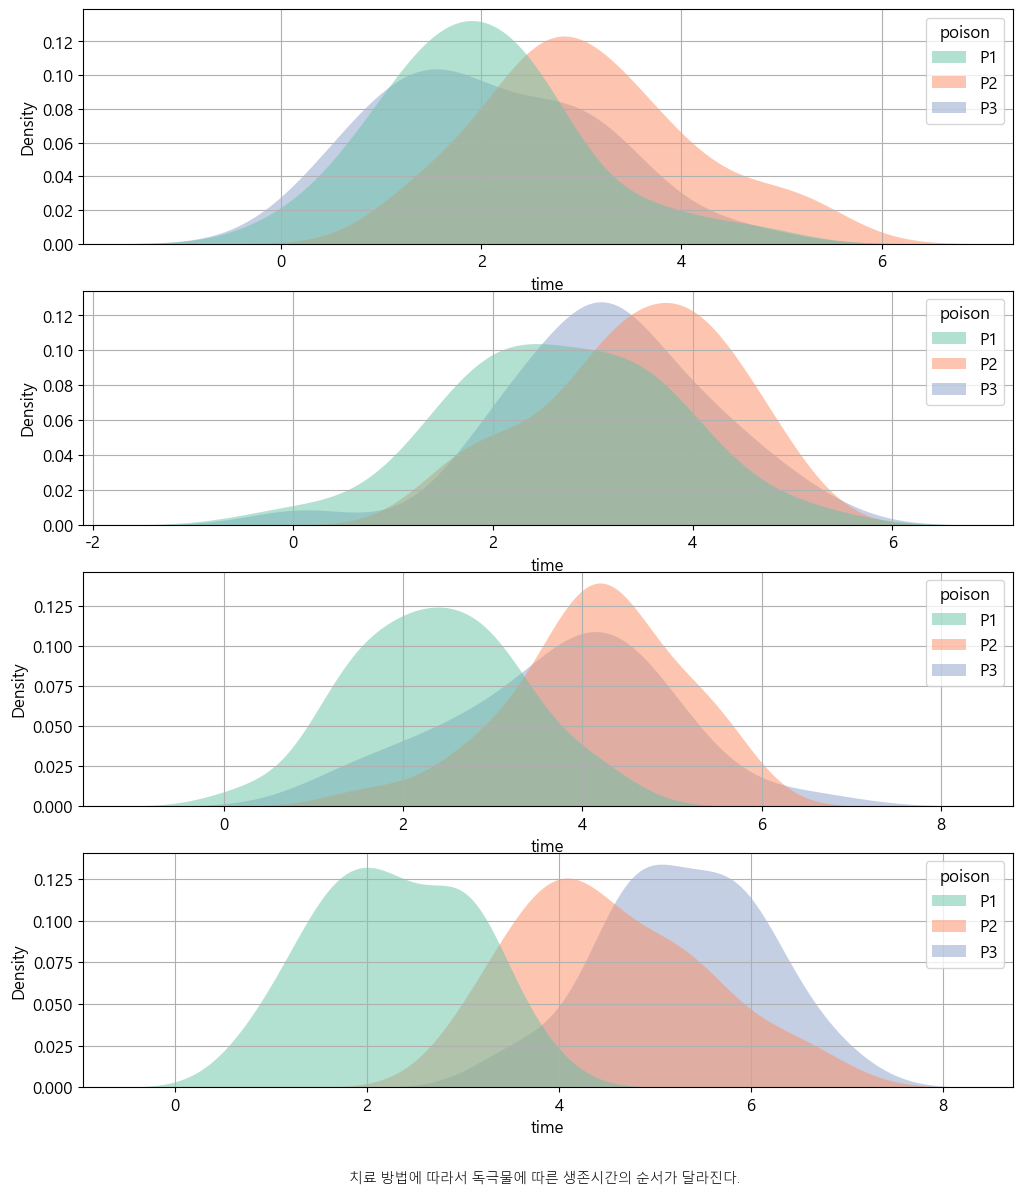

In [14]:
treat = df2['treat'].unique()
s = len(treat)

fig, ax = plt.subplots(s, 1, figsize=(12, 3.5*s))

for i, v in enumerate(ax):
    data = df2[df2['treat'] == treat[i]]
    sb.kdeplot(data=data, x='time', hue='poison', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()

txt = """치료 방법에 따라서 독극물에 따른 생존시간의 순서가 달라진다."""

plt.figtext(0.51, 0.05, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

In [72]:
poison = df2['poison'].unique()
treat = df2['treat'].unique()

for i in poison:
    for j in treat:
        data = df2[(df2['poison'] == i) & (df2['treat'] == j)]['time']
        s, p = normaltest(data)
        print("[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}".format(i, j, s, p, p > 0.05))

[P1 + T1] statistic: 3.661, p-value: 0.160, 정규성 충족 여부: True
[P1 + T2] statistic: 0.266, p-value: 0.875, 정규성 충족 여부: True
[P1 + T3] statistic: 0.014, p-value: 0.993, 정규성 충족 여부: True
[P1 + T4] statistic: 1.476, p-value: 0.478, 정규성 충족 여부: True
[P2 + T1] statistic: 1.112, p-value: 0.573, 정규성 충족 여부: True
[P2 + T2] statistic: 1.510, p-value: 0.470, 정규성 충족 여부: True
[P2 + T3] statistic: 2.802, p-value: 0.246, 정규성 충족 여부: True
[P2 + T4] statistic: 1.662, p-value: 0.436, 정규성 충족 여부: True
[P3 + T1] statistic: 0.837, p-value: 0.658, 정규성 충족 여부: True
[P3 + T2] statistic: 3.667, p-value: 0.160, 정규성 충족 여부: True
[P3 + T3] statistic: 0.425, p-value: 0.809, 정규성 충족 여부: True
[P3 + T4] statistic: 0.164, p-value: 0.921, 정규성 충족 여부: True


In [16]:
fields = []

for i in poison:
    for j in treat:
        data = df2[(df2['poison'] == i) & (df2['treat'] == j)]['time']
        fields.append(data)

s, p = bartlett(*fields)
print("statistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05))

statistic: 8.154, p-value: 0.699, 등분산성 충족 여부: True


In [17]:
formula = 'time ~ C(poison)*C(treat)'
lm = ols(formula, df2).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(poison),2.0,148.976389,74.488194,74.722166,1.002877e-27
C(treat),3.0,131.260972,43.753657,43.891090,4.430485e-24
C(poison):C(treat),6.0,81.381611,13.563602,13.606206,6.938981e-14
Residual,348.0,346.910333,0.996869,NaN,NaN


- 사용한 독극물과 치료방법에 따라서는 생존시간에 유의미한 차이가 있으나 (P <= 0.5), 독극물과 치료방법의 상호작용에 따른 생존시간에는 교효작용이 없었다. (P > 0.5) 이는 독극물에 대해서 적합한 효과를 볼 수 있는 치료방법이 달라짐을 의미한다.

## 연습문제 3

In [18]:
df3 = pd.read_excel("https://data.hossam.kr/mldata/tomato.xlsx")
df3

,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4
...,...,...
85,1000,15.8
86,1000,14.5
87,1000,13.5
88,1000,15.0


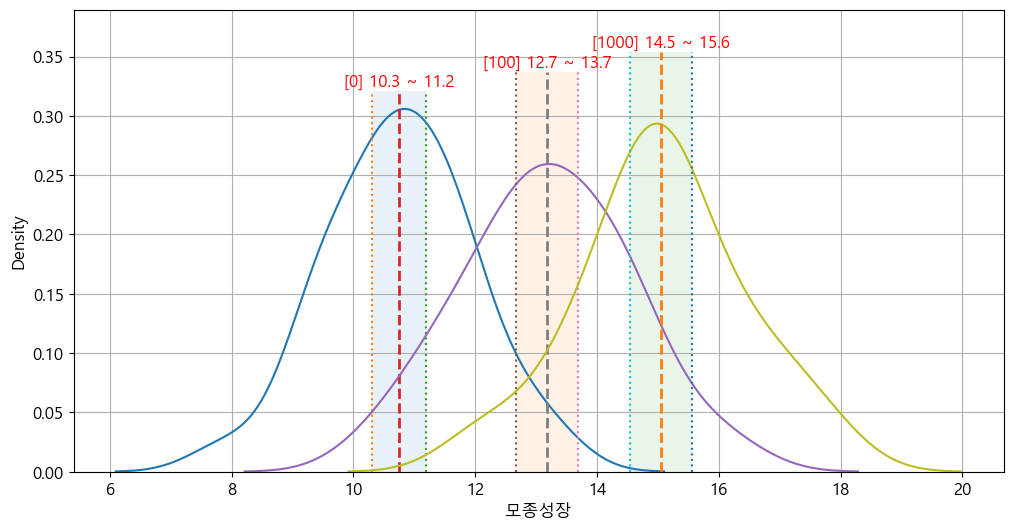

In [19]:
plt.figure(figsize = (12, 6))

for c in df3['효소함량'].unique():
    #print(c)

    data = df3[df3['효소함량'] == c]['모종성장']                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [68]:
for c in df3['효소함량'].unique():
    s, p = normaltest(df3[df3['효소함량'] == c]['모종성장'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[0] statistic: 0.238, p-value: 0.888, 정규성 충족 여부: True
[100] statistic: 0.000, p-value: 1.000, 정규성 충족 여부: True
[1000] statistic: 0.235, p-value: 0.889, 정규성 충족 여부: True


In [21]:
normal_dist = False      # 정규성 만족 여부
data = df3.copy()    # 원본 데이터 복사
fields = []
for i in data['효소함량'].unique():
    tmp = data[data['효소함량'] == i]['모종성장']
    fields.append(tmp)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Levene 검정: statistic: 0.295, p-value: 0.745, 등분산성 충족 여부: True


In [22]:
s, p = f_oneway(*fields)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.094, p-value: 0.000, 대립가설 채택'

- 귀무가설이 기각되어 효소함량에 따른 모종성장의 차이는 있는 것으로 확인되었다. (P <= 0.5)

In [23]:
lm = ols('모종성장 ~ C(효소함량)', data=df3).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(효소함량),2.0,279.292667,139.646333,81.094169,1.318657e-20
Residual,87.0,149.816333,1.722027,NaN,NaN


In [24]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.094, p-value: 0.000, 대립가설 채택'

In [25]:
tukey = pairwise_tukeyhsd(df3['모종성장'], df3['효소함량'], alpha = 0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,100,2.4267,0.0,1.6187,3.2346,True
0,1000,4.3033,0.0,3.4954,5.1113,True
100,1000,1.8767,0.0,1.0687,2.6846,True


- 5000, 10000의 효소함량이 0, 1000 효소함량보다 모종성장이 유의미하게 낮은 결과를 보인 것으로 보아 효소함량이 지나치게 많을 경우 모종성장에 악영향을 미치는 것으로 보인다.

## 연습문제 4

In [26]:
df4 = pd.read_excel("https://data.hossam.kr/mldata/reading.xlsx")
df4

,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3
...,...,...
85,G,13.6
86,G,18.4
87,G,17.0
88,G,11.7


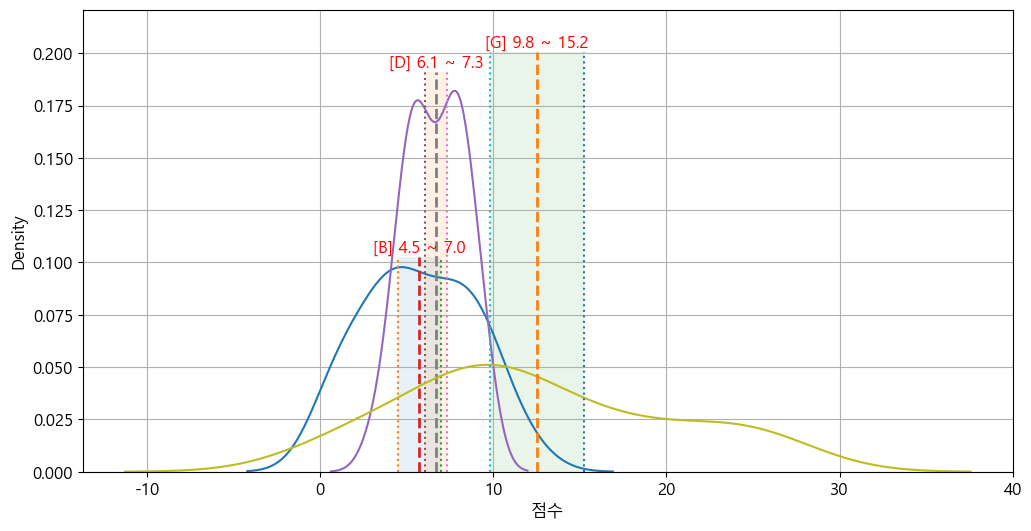

In [27]:
plt.figure(figsize = (12, 6))

for c in df4['독서방법'].unique():
    #print(c)

    data = df4[df4['독서방법'] == c]['점수']                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [70]:
for c in df4['독서방법'].unique():
    s, p = normaltest(df4[df4['독서방법'] == c]['점수'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[B] statistic: 2.210, p-value: 0.331, 정규성 충족 여부: True
[D] statistic: 2.397, p-value: 0.302, 정규성 충족 여부: True
[G] statistic: 2.217, p-value: 0.330, 정규성 충족 여부: True


In [29]:
normal_dist = True      # 정규성 만족 여부
data = df4.copy()    # 원본 데이터 복사
fields = []
for i in data['독서방법'].unique():
    tmp = data[data['독서방법'] == i]['점수']
    fields.append(tmp)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 58.099, p-value: 0.000, 등분산성 충족 여부: False


In [30]:
s, p = f_oneway(*fields)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 17.209, p-value: 0.000, 대립가설 채택'

- p-value가 0.482로 귀무가설이 채택되어 독서방법에 따른 평가점수 차이는 없는 것으로 확인되었다.

In [31]:
lm = ols('점수 ~ C(독서방법)', data=df4).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(독서방법),2.0,832.380512,416.190256,17.208501,5.045789e-07
Residual,87.0,2104.108488,24.185155,NaN,NaN


In [32]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 17.209, p-value: 0.000, 대립가설 채택'

In [33]:
comp = MultiComparison(df4['점수'], df4['독서방법'])
result = comp.allpairtest(ttest_ind, method='bonf', alpha = 0.05)
result[0]

group1,group2,stat,pval,pval_corr,reject
B,D,-1.4487,0.153,0.459,False
B,G,-4.4514,0.0,0.0001,True
D,G,-4.1589,0.0001,0.0003,True


## 연습문제 5

In [34]:
df5 = pd.read_excel("https://data.hossam.kr/mldata/edu.xlsx")
df5

,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65
5,1,69,70
6,1,55,79
7,1,76,80
8,1,77,76
9,1,70,90


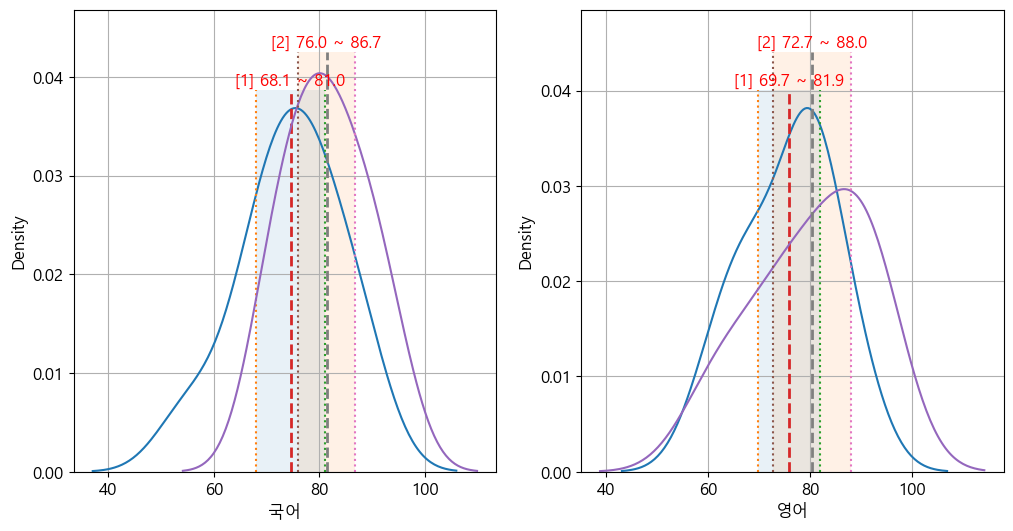

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
li_class = ['국어', '영어']

for i, v in enumerate(li_class):
    tmp = df5[['교육방법', v]]
    for c in tmp['교육방법'].unique():
        #print(c)

        data = tmp[tmp['교육방법'] == c][v]                                # 데이터만 추출
        max = data.max()                                # 최대값
        clevel = 0.95                                   # 신뢰수준
        dof = len(data) - 1                             # 자유도
        sample_mean = data.mean()                       # 표본평균
        sample_std = data.std(ddof=1)                   # 표본표준편차
        sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

        # 신뢰구간
        cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

        sb.kdeplot(data=data, ax = ax[i])

        xmin, xmax, ymin, ymax = ax[i].axis()

        # 신뢰구간 그리기
        ax[i].plot([cmin, cmin], [0, ymax], linestyle=':')
        ax[i].plot([cmax, cmax], [0, ymax], linestyle=':')
        ax[i].fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

        # 평균 그리기
        ax[i].plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 12, "color": "red"})

        ax[i].set_ylim(0, ymax * 1.1)
        ax[i].grid(True)
plt.show()
plt.close()

In [71]:
for i in li_class:
    for c in df5['교육방법'].unique():
        s, p = normaltest(df5[df5['교육방법'] == c][i])
        print("[{0}, {4}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05, i))

[1, 국어] statistic: 0.911, p-value: 0.634, 정규성 충족 여부: True
[2, 국어] statistic: 0.300, p-value: 0.861, 정규성 충족 여부: True
[1, 영어] statistic: 0.389, p-value: 0.823, 정규성 충족 여부: True
[2, 영어] statistic: 1.095, p-value: 0.578, 정규성 충족 여부: True


In [37]:
normal_dist = True      # 정규성 만족 여부
data = df5.copy()    # 원본 데이터 복사

for j in li_class:
    fields = []
    for i in data['교육방법'].unique():
        tmp = data[data['교육방법'] == i][j]
        fields.append(tmp)

    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*fields)
    else:
        n = "Levene"
        s, p = levene(*fields)

    print("[{4}] {0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05, j))

[국어] Bartlett 검정: statistic: 0.334, p-value: 0.563, 등분산성 충족 여부: True
[영어] Bartlett 검정: statistic: 0.486, p-value: 0.486, 등분산성 충족 여부: True


In [38]:
for j in li_class:
    fields = []
    for i in data['교육방법'].unique():
        tmp = data[data['교육방법'] == i][j]
        fields.append(tmp)

    s, p = f_oneway(*fields)
    print("[{3}] statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무", j))

[국어] statistic: 3.250, p-value: 0.086, 귀무가설 채택
[영어] statistic: 1.072, p-value: 0.313, 귀무가설 채택


In [39]:
lm = ols('국어 ~ C(교육방법)', data=df5).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(교육방법),1.0,255.681818,255.681818,3.250318,0.086499
Residual,20.0,1573.272727,78.663636,NaN,NaN


In [40]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 3.250, p-value: 0.086, 귀무가설 채택'

In [41]:
lm = ols('영어 ~ C(교육방법)', data=df5).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(교육방법),1.0,113.636364,113.636364,1.071949,0.312863
Residual,20.0,2120.181818,106.009091,NaN,NaN


In [42]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 1.072, p-value: 0.313, 귀무가설 채택'

In [43]:
tukey = pairwise_tukeyhsd(df5['국어'], df5['교육방법'], alpha = 0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,6.8182,0.0865,-1.0706,14.707,False


In [44]:
tukey = pairwise_tukeyhsd(df5['영어'], df5['교육방법'], alpha = 0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,4.5455,0.3129,-4.6125,13.7034,False


- 검정 결과 p-value 상으로는 국어와 영어 모두 교육방법에 따른 성적의 유의미한 차이는 없는 것으로 확인되었다. 다만 2번 교육방법을 사용하였을 경우 오차 범위 내에서 국어와 영어 모두 근소하게 2번의 성적이 더 좋았다.

In [45]:
df5_2 = df5.melt(id_vars = '교육방법', value_vars = ['국어', '영어'], value_name = '점수', var_name = '과목')
df5_2.head()

,교육방법,과목,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81


In [46]:
lm = ols('점수 ~ C(과목)*C(교육방법)', data=df5_2).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(과목),1.0,0.204545,0.204545,0.002215,0.962695
C(교육방법),1.0,355.113636,355.113636,3.845870,0.056857
C(과목):C(교육방법),1.0,14.204545,14.204545,0.153835,0.696979
Residual,40.0,3693.454545,92.336364,NaN,NaN


## 연습문제 6

In [47]:
df6 = pd.read_excel("https://data.hossam.kr/mldata/commercial.xlsx")
df6

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166
...,...,...,...,...,...,...
6217,4,3130323,전통시장,둔촌역전통시장,13523478306,535132
6218,4,3130324,전통시장,길동복조리시장,6236556030,330148
6219,4,3130325,전통시장,명일전통시장,3973269286,186049
6220,4,3130326,전통시장,고덕 골목형상점가,15013907999,755565


### 1) 상권 종류별 2023 한 해 동안의 평균 매출액의 차이

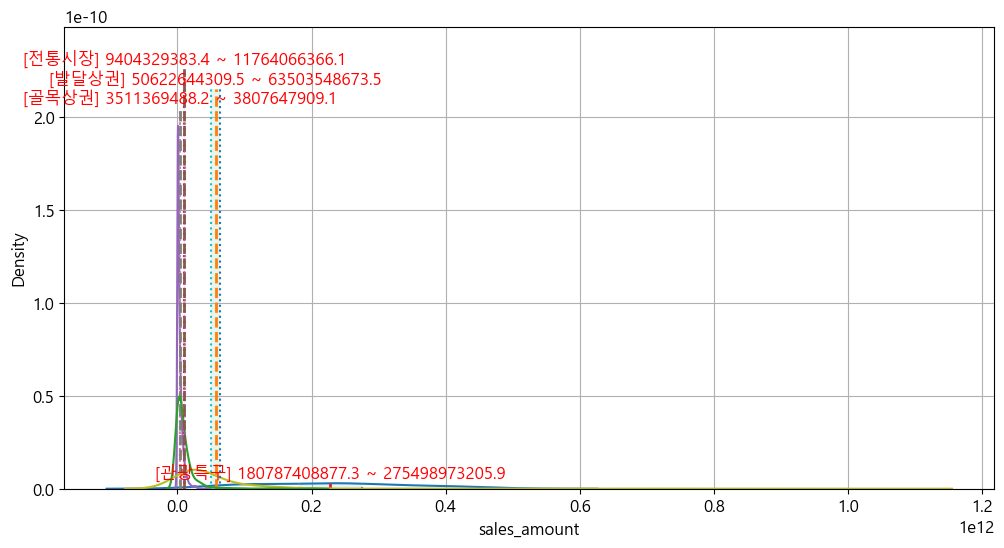

In [48]:
plt.figure(figsize = (12, 6))

for c in df6['type'].unique():
    #print(c)

    data = df6[df6['type'] == c]['sales_amount']                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

- 일반 그래프로는 상권별 단위차이가 커서 데이터 분석이 어렵다.

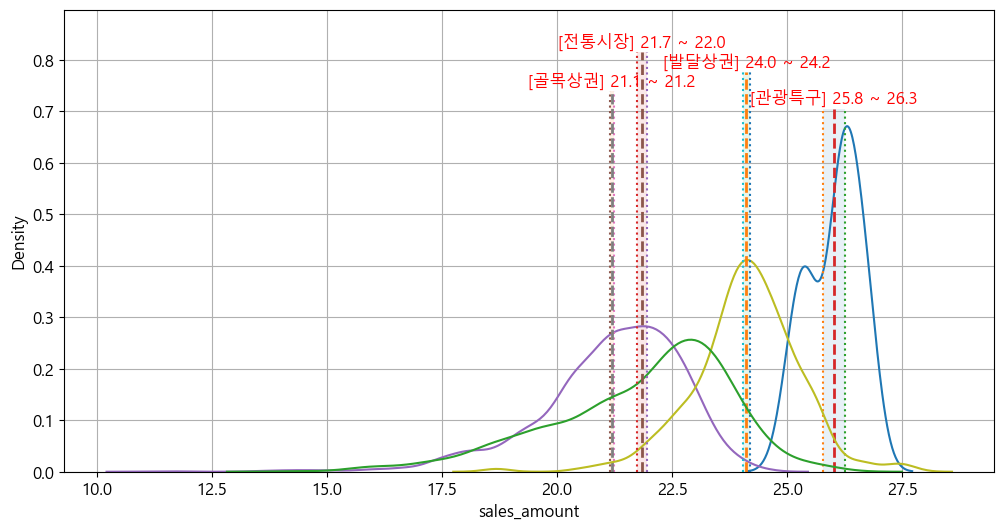

In [49]:
plt.figure(figsize = (12, 6))

for c in df6['type'].unique():
    #print(c)

    data = np.log(df6[df6['type'] == c]['sales_amount'])                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

- 로그변환으로 상대적 크기만 비교

In [50]:
for c in df6['type'].unique():
    tmp = df6[df6['type'] == c]['sales_amount']
    s, p = normaltest(tmp)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[관광특구] statistic: 2.023, p-value: 0.364, 정규성 충족 여부: True
[골목상권] statistic: 2949.769, p-value: 0.000, 정규성 충족 여부: False
[발달상권] statistic: 1174.364, p-value: 0.000, 정규성 충족 여부: False
[전통시장] statistic: 1194.780, p-value: 0.000, 정규성 충족 여부: False


In [51]:
for c in df6['type'].unique():
    tmp = df6[df6['type'] == c]['sales_amount']
    s, p = normaltest(np.log(tmp))
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[관광특구] statistic: 3.776, p-value: 0.151, 정규성 충족 여부: True
[골목상권] statistic: 850.893, p-value: 0.000, 정규성 충족 여부: False
[발달상권] statistic: 84.529, p-value: 0.000, 정규성 충족 여부: False
[전통시장] statistic: 100.319, p-value: 0.000, 정규성 충족 여부: False


- 정규성을 만족하지 않는다.

In [52]:
normal_dist = False      # 정규성 만족 여부
data = df6.copy()    # 원본 데이터 복사
fields = []
for i in data['type'].unique():
    tmp = data[data['type'] == i]['sales_amount']
    fields.append(tmp)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Levene 검정: statistic: 268.725, p-value: 0.000, 등분산성 충족 여부: False


- 등분산성도 만족하지 않는다.

In [53]:
s, p = f_oneway(*fields)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 612.137, p-value: 0.000, 대립가설 채택'

In [54]:
lm = ols('sales_amount ~ C(type)', data=df6).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(type),3.0,3.397583e+24,1.132528e+24,612.136531,0.0
Residual,6218.0,1.150406e+25,1.850123e+21,NaN,NaN


In [55]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 612.137, p-value: 0.000, 대립가설 채택'

- p-value가 0으로 귀무가설이 기각되어 상권별 2023년 매출액에는 유의미한 차이가 있다.

In [56]:
result = pairwise_gameshowell(df6, dv='sales_amount', between='type')
result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,골목상권,관광특구,3.659509e+09,2.281432e+11,-2.244837e+11,2.289216e+10,-9.806138,23.000501,6.410146e-09,-23.206979
1,골목상권,발달상권,3.659509e+09,5.706310e+10,-5.340359e+10,3.282878e+09,-16.267309,996.054989,7.271961e-14,-1.160433
2,골목상권,전통시장,3.659509e+09,1.058420e+10,-6.924689e+09,6.060559e+08,-11.425826,1143.188337,0.000000e+00,-0.679464
3,관광특구,발달상권,2.281432e+11,5.706310e+10,1.710801e+11,2.312611e+10,7.397704,23.954998,7.128281e-07,1.647276
4,관광특구,전통시장,2.281432e+11,1.058420e+10,2.175590e+11,2.289993e+10,9.500421,23.031751,1.140238e-08,8.536768
5,발달상권,전통시장,5.706310e+10,1.058420e+10,4.647890e+10,3.336641e+09,13.929848,1061.849622,3.926859e-13,0.638976


- 사후 분석 결과로는 '골목상권 < 전통시장 < 발달상권 < 관광특구' 순으로 매출액의 차이를 보였다.

### 2) 상권 종류별로 2023년 분기별 평균 매출액 차이

In [57]:
df6.head()

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


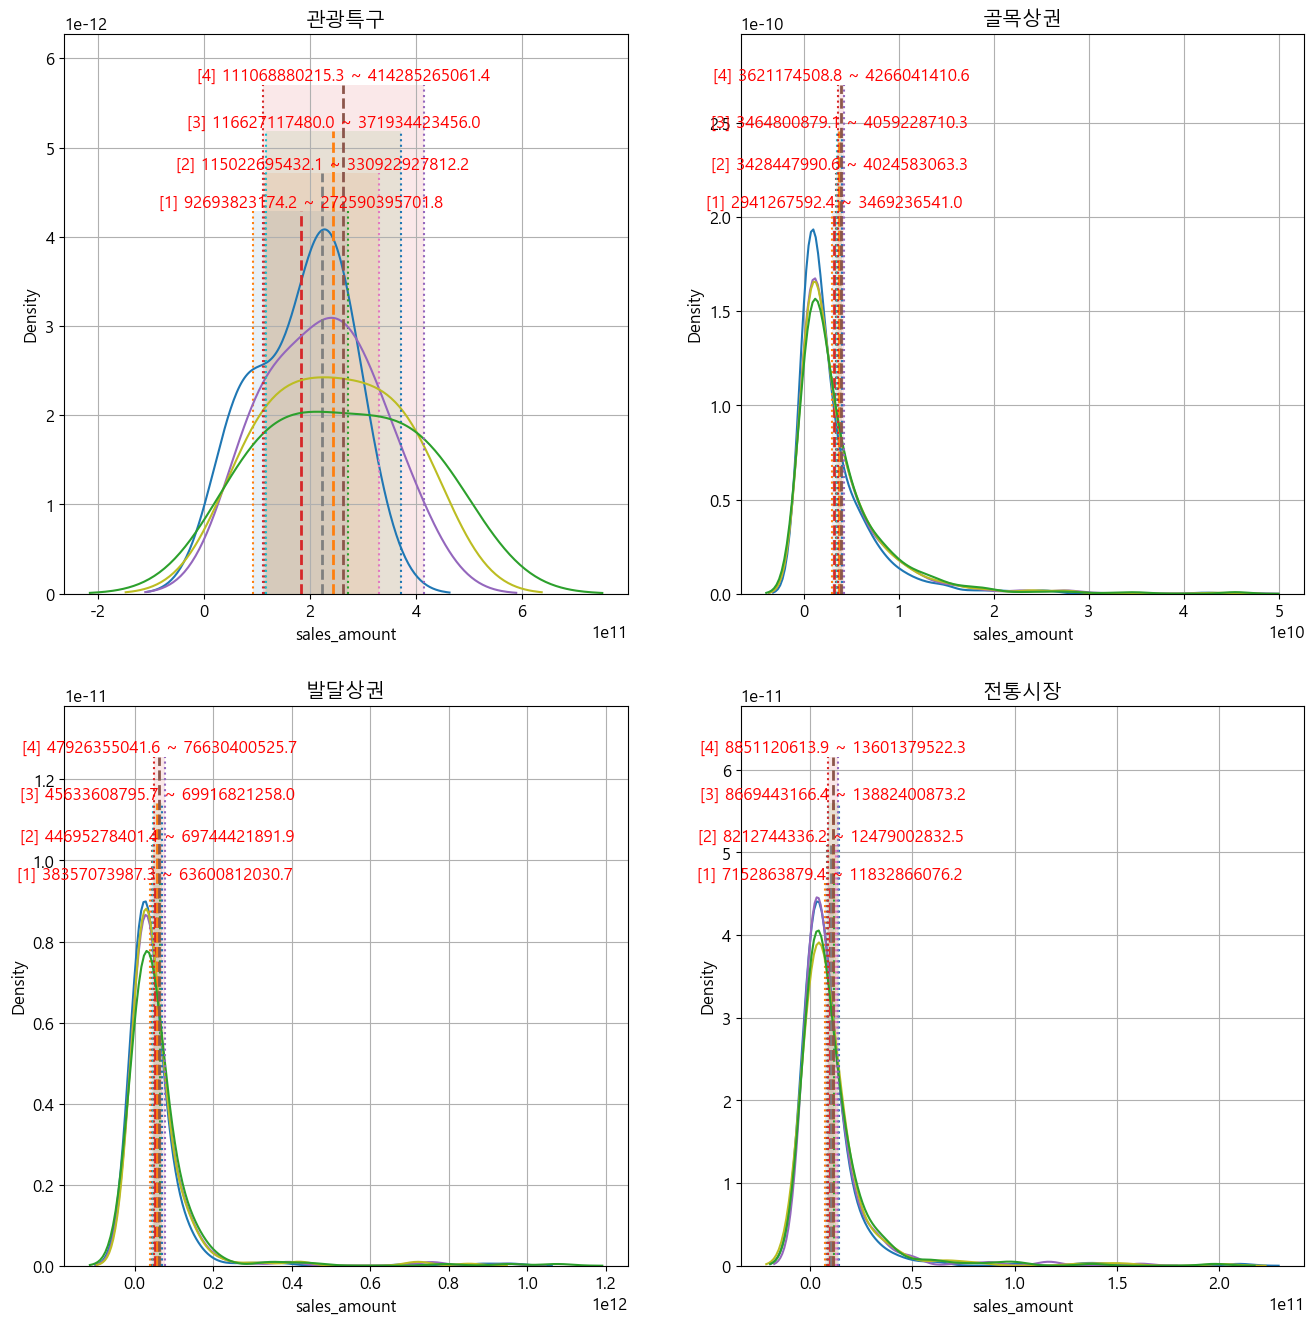

In [58]:
fig, ax = plt.subplots(2, 2, figsize = (16, 16))
ax_1d = ax.flatten()

for i, v in enumerate(df6['type'].unique()):
    tmp = df6[df6['type'] == v]
    for c in tmp['quarter'].unique():
        #print(c)

        data = tmp[tmp['quarter'] == c]['sales_amount']                                # 데이터만 추출
        max = data.max()                                # 최대값
        clevel = 0.95                                   # 신뢰수준
        dof = len(data) - 1                             # 자유도
        sample_mean = data.mean()                       # 표본평균
        sample_std = data.std(ddof=1)                   # 표본표준편차
        sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

        # 신뢰구간
        cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

        sb.kdeplot(data=data, ax = ax_1d[i])

        xmin, xmax, ymin, ymax = ax_1d[i].axis()

        # 신뢰구간 그리기
        ax_1d[i].plot([cmin, cmin], [0, ymax], linestyle=':')
        ax_1d[i].plot([cmax, cmax], [0, ymax], linestyle=':')
        ax_1d[i].fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

        # 평균 그리기
        ax_1d[i].plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

        ax_1d[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 12, "color": "red"})

        ax_1d[i].set_ylim(0, ymax * 1.1)
        ax_1d[i].grid(True)
        ax_1d[i].set_title(v)
plt.show()
plt.close()

In [59]:
for i in df6['type'].unique():
    tmp = df6[df6['type'] == i]
    for c in df6['quarter'].unique():
        tmp_2 = tmp[tmp['quarter'] == c]['sales_amount']
        try:
            by = 'Normaltest'
            s, p = normaltest(tmp_2)
        except:
            by = 'Shapiro'
            s, p = shapiro(tmp_2)            
        print("[{0}분기 {4}] {5} statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05, i, by))

[1분기 관광특구] Shapiro statistic: 0.861, p-value: 0.191, 정규성 충족 여부: True
[2분기 관광특구] Shapiro statistic: 0.927, p-value: 0.560, 정규성 충족 여부: True
[3분기 관광특구] Shapiro statistic: 0.872, p-value: 0.236, 정규성 충족 여부: True
[4분기 관광특구] Shapiro statistic: 0.946, p-value: 0.710, 정규성 충족 여부: True
[1분기 골목상권] Normaltest statistic: 788.125, p-value: 0.000, 정규성 충족 여부: False
[2분기 골목상권] Normaltest statistic: 734.747, p-value: 0.000, 정규성 충족 여부: False
[3분기 골목상권] Normaltest statistic: 711.993, p-value: 0.000, 정규성 충족 여부: False
[4분기 골목상권] Normaltest statistic: 778.041, p-value: 0.000, 정규성 충족 여부: False
[1분기 발달상권] Normaltest statistic: 348.085, p-value: 0.000, 정규성 충족 여부: False
[2분기 발달상권] Normaltest statistic: 324.973, p-value: 0.000, 정규성 충족 여부: False
[3분기 발달상권] Normaltest statistic: 302.116, p-value: 0.000, 정규성 충족 여부: False
[4분기 발달상권] Normaltest statistic: 330.454, p-value: 0.000, 정규성 충족 여부: False
[1분기 전통시장] Normaltest statistic: 372.481, p-value: 0.000, 정규성 충족 여부: False
[2분기 전통시장] Normaltest statistic: 295.650, p-value

In [60]:
for i in df6['type'].unique():
    tmp = df6[df6['type'] == i]
    for c in df6['quarter'].unique():
        tmp_2 = np.log(tmp[tmp['quarter'] == c]['sales_amount'])
        try:
            by = 'Normaltest'
            s, p = normaltest(tmp_2)
        except:
            by = 'Shapiro'
            s, p = shapiro(tmp_2)            
        print("[{0}분기 {4}] {5} statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05, i, by))

[1분기 관광특구] Shapiro statistic: 0.802, p-value: 0.061, 정규성 충족 여부: True
[2분기 관광특구] Shapiro statistic: 0.891, p-value: 0.324, 정규성 충족 여부: True
[3분기 관광특구] Shapiro statistic: 0.853, p-value: 0.165, 정규성 충족 여부: True
[4분기 관광특구] Shapiro statistic: 0.930, p-value: 0.577, 정규성 충족 여부: True
[1분기 골목상권] Normaltest statistic: 144.142, p-value: 0.000, 정규성 충족 여부: False
[2분기 골목상권] Normaltest statistic: 263.522, p-value: 0.000, 정규성 충족 여부: False
[3분기 골목상권] Normaltest statistic: 246.283, p-value: 0.000, 정규성 충족 여부: False
[4분기 골목상권] Normaltest statistic: 220.399, p-value: 0.000, 정규성 충족 여부: False
[1분기 발달상권] Normaltest statistic: 22.394, p-value: 0.000, 정규성 충족 여부: False
[2분기 발달상권] Normaltest statistic: 26.111, p-value: 0.000, 정규성 충족 여부: False
[3분기 발달상권] Normaltest statistic: 24.465, p-value: 0.000, 정규성 충족 여부: False
[4분기 발달상권] Normaltest statistic: 25.462, p-value: 0.000, 정규성 충족 여부: False
[1분기 전통시장] Normaltest statistic: 32.540, p-value: 0.000, 정규성 충족 여부: False
[2분기 전통시장] Normaltest statistic: 25.993, p-value: 0.00

In [61]:
normal_dist = [True, False, False, False]      # 정규성 만족 여부
data = df6.copy()    # 원본 데이터 복사

for k, j in enumerate(data['type'].unique()):
    tmp = data[data['type'] == j]
    fields = []
    for i in tmp['quarter'].unique():
        tmp_2 = tmp[tmp['quarter'] == i]['sales_amount']
        fields.append(tmp_2)

    if normal_dist[k]:
        n = "Bartlett"
        s, p = bartlett(*fields)
    else:
        n = "Levene"
        s, p = levene(*fields)

    print("[{4}] {0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05, j))

[관광특구] Bartlett 검정: statistic: 1.360, p-value: 0.715, 등분산성 충족 여부: True
[골목상권] Levene 검정: statistic: 2.954, p-value: 0.031, 등분산성 충족 여부: False
[발달상권] Levene 검정: statistic: 0.243, p-value: 0.867, 등분산성 충족 여부: True
[전통시장] Levene 검정: statistic: 0.381, p-value: 0.767, 등분산성 충족 여부: True


In [62]:
for i in df6['type'].unique():
    tmp = df6[df6['type'] == i]
    fields = []
    for j in tmp['quarter'].unique():
        fields.append(tmp[tmp['quarter'] == j]['sales_amount'])
    s, p = f_oneway(*fields)
    print("[{3}] statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무", i))

[관광특구] statistic: 0.530, p-value: 0.667, 귀무가설 채택
[골목상권] statistic: 4.416, p-value: 0.004, 대립가설 채택
[발달상권] statistic: 0.500, p-value: 0.682, 귀무가설 채택
[전통시장] statistic: 0.493, p-value: 0.687, 귀무가설 채택


In [63]:
for i in df6['type'].unique():
    tmp = df6[df6['type'] == i]
    lm = ols('sales_amount ~ C(quarter)', data=tmp).fit()
    anova = anova_lm(lm)
    print(tabulate(anova, headers='keys', tablefmt='psql', showindex=True))
    s = anova['F'][0]
    p = anova['PR(>F)'][0]
    print("[{3}] statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무", i), end="\n\n")

+------------+------+-------------+-------------+------------+------------+
|            |   df |      sum_sq |     mean_sq |          F |     PR(>F) |
|------------+------+-------------+-------------+------------+------------|
| C(quarter) |    3 | 2.13006e+22 | 7.10018e+21 |   0.529919 |   0.666905 |
| Residual   |   20 | 2.67972e+23 | 1.33986e+22 | nan        | nan        |
+------------+------+-------------+-------------+------------+------------+
[관광특구] statistic: 0.530, p-value: 0.667, 귀무가설 채택

+------------+------+-------------+------------+-----------+--------------+
|            |   df |      sum_sq |    mean_sq |         F |       PR(>F) |
|------------+------+-------------+------------+-----------+--------------|
| C(quarter) |    3 | 3.08821e+20 | 1.0294e+20 |   4.41614 |   0.00416739 |
| Residual   | 4089 | 9.53146e+22 | 2.331e+19  | nan       | nan          |
+------------+------+-------------+------------+-----------+--------------+
[골목상권] statistic: 4.416, p-value: 0.00

In [64]:
for i in df6['type'].unique():
    tmp = df6[df6['type'] == i]
    result = pairwise_gameshowell(tmp, dv='sales_amount', between='quarter')
    print(f"[{i}]")
    print(tabulate(result, headers='keys', tablefmt='psql', showindex=False), end = "\n\n")

[관광특구]
+-----+-----+-------------+-------------+--------------+-------------+-----------+---------+----------+-----------+
|   A |   B |     mean(A) |     mean(B) |         diff |          se |         T |      df |     pval |    hedges |
|-----+-----+-------------+-------------+--------------+-------------+-----------+---------+----------+-----------|
|   1 |   2 | 1.82642e+11 | 2.22973e+11 | -4.03307e+10 | 5.4662e+10  | -0.73782  | 9.68469 | 0.879645 | -0.393213 |
|   1 |   3 | 1.82642e+11 | 2.44281e+11 | -6.16387e+10 | 6.07491e+10 | -1.01464  | 8.98311 | 0.745445 | -0.540742 |
|   1 |   4 | 1.82642e+11 | 2.62677e+11 | -8.0035e+10  | 6.85771e+10 | -1.16708  | 8.13193 | 0.661863 | -0.621982 |
|   2 |   3 | 2.22973e+11 | 2.44281e+11 | -2.1308e+10  | 6.50353e+10 | -0.327637 | 9.73152 | 0.987112 | -0.17461  |
|   2 |   4 | 2.22973e+11 | 2.62677e+11 | -3.97043e+10 | 7.24014e+10 | -0.548391 | 9.03322 | 0.944677 | -0.292259 |
|   3 |   4 | 2.44281e+11 | 2.62677e+11 | -1.83963e+10 | 7.71005e

- 상권별로 분리하여 분석한 결과로는 골목상권을 제외하고는 분기별로 매출액에 유의미한 차이가 없었다.
  - 골목상권의 경우 4분기로 갈수록 매출이 증가하는 현상을 보였다.

In [65]:
normal_dist = False      # 정규성 만족 여부
data = df6.copy()    # 원본 데이터 복사
fields = []

for k, j in enumerate(data['type'].unique()):
    tmp = data[data['type'] == j]
    for i in tmp['quarter'].unique():
        tmp_2 = tmp[tmp['quarter'] == i]['sales_amount']
        fields.append(tmp_2)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Levene 검정: statistic: 53.903, p-value: 0.000, 등분산성 충족 여부: False


In [66]:
formula = 'sales_amount ~ C(type)*C(quarter)'
lm = ols(formula, df6).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(type),3.0,3.397583e+24,1.132528e+24,612.997343,0.000000
C(quarter),3.0,6.915692e+21,2.305231e+21,1.247740,0.290658
C(type):C(quarter),9.0,3.140937e+22,3.489930e+21,1.888976,0.048918
Residual,6206.0,1.146574e+25,1.847525e+21,NaN,NaN


- 상권별로는 매출에 유의미한 차이가 있으며, 분기별로는 유의미한 차이가 없었다. 상권과 분기간 상호작용에 의한 매출 변화에 교효작용이 있었다.
  - 골목상권에 한하여 분기별로 유의미한 차이가 있었기 때문에 위와 같은 결과가 도출된 것으로 보인다.